In [1]:
import math
import os
import random as rng
import sys
from typing import Iterator

import cv2 as cv
import gpxpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lp_tracking import Lamppost, Lp_container, wgs_to_rd, rd_to_wgs


In [2]:
def number_gen() -> Iterator[int]:
    """
    Natural number generator

    :return: the next integer in the sequence of natural numbers
    :rtype: Iterator[int]
    """
    num = 0
    while True:
        yield num
        num += 1


def color_gen() -> tuple:
    """
    Random (r,g,b) color generator

    :return: tuple of (r,g,b)
    :rtype: tuple
    """
    return tuple(np.random.choice(range(256), size=3).tolist())


def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 6372.8 # Radius of earth in kilometers.
    return c * r * 1000

cv2 = cv


def detect_frame(im):
    img = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    img = cv.medianBlur(img, 5)
    kernel = np.ones((12, 12), np.uint8)
    img = cv.erode(img, kernel, iterations=3)
    img = cv.dilate(img, kernel, iterations=3)

    # cv.imshow("AAAAAAAA", img)

    perc = 0.01
    hist = cv.calcHist([img[:324]], [0], None, [256], [0, 256]).flatten()

    total = img.shape[0] * img.shape[1]
    target = perc * total
    # print(target)
    summed = 0
    thresh = 0
    for i in range(255, 0, -1):
        summed += int(hist[i])
        if summed >= target:
            thresh = i
            break

    ret = cv.threshold(img, thresh < 255 and thresh or 254, 0, cv.THRESH_TOZERO)[1]

    contours = cv2.findContours(ret[:, :960], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    contours_poly = [None] * len(contours)
    boundRect = [None] * len(contours)
    centers = [None] * len(contours)
    radius = [None] * len(contours)
    for i, c in enumerate(contours):
        contours_poly[i] = cv.approxPolyDP(c, 3, True)
        boundRect[i] = cv.boundingRect(contours_poly[i])
        centers[i], radius[i] = cv.minEnclosingCircle(contours_poly[i])

    for i in range(len(contours)):
        color = (rng.randint(0, 256), rng.randint(0, 256), rng.randint(0, 256))
        color = (0, 255, 0)
        if centers[i][1] <= 0.3 * 1080 and radius[i] < 100:
            cv.rectangle(im, (int(boundRect[i][0]), int(boundRect[i][1])),
                         (int(boundRect[i][0] + boundRect[i][2]), int(boundRect[i][1] + boundRect[i][3])), color, 2)

    return boundRect

In [13]:
def demo():
    lp_container = Lp_container()
    # cas = Cascader("models/cascade.xml")
    id_gen = number_gen()
    cap = cv.VideoCapture("input/Amsterdam/AMSTERDAM_OSV.mp4")
    idx = 0

    with open("input/Amsterdam/AMSTERDAM_OSV.gpx") as f:
        gpx = gpxpy.parse(f)

    segments = gpx.tracks[0].segments[0]
    gps_coords = pd.DataFrame([
        {'lat': p.latitude,
         'lon': p.longitude,
         'ele': p.elevation,
         'time': p.time} for p in segments.points])

    lats = [gps_coords.lat[0]]
    lons = [gps_coords.lon[0]]

    figure, ax = plt.subplots(figsize=(8, 6))

    for idx in range(24):
        _, frame = cap.read()
        rdx, rdy = wgs_to_rd(lats[idx % 24], lons[idx % 24])
        if idx % 24 == 0:
            # lp_coors = cas.cascade_frame(frame)
            lp_coors = detect_frame(frame)
            lats = np.linspace(gps_coords.lat[math.floor(idx / 24)], gps_coords.lat[math.floor(idx / 24 + 1)], num=24)
            lons = np.linspace(gps_coords.lon[math.floor(idx / 24)], gps_coords.lon[math.floor(idx / 24 + 1)], num=24)

            for x, y, w, h in lp_coors:
                match = lp_container.find_matching_lp((x, y))

                if not match:
                    lp = Lamppost(x, y, w, h, next(id_gen), color_gen(), frame, (rdx, rdy))
                    lp_container.add_lp(lp)
                else:
                    match.update_bbox(x, y, w, h)
                    match.add_loc((rdx, rdy))
                    match.get_angle()
        else:
            for lp in lp_container.get_lps():
                if not lp.tracker_update(frame):
                    # lp_container.del_lp(lp)
                    lp.inc_decay()
                else:
                    lp_container.find_matching_lp(lp.get_coor())
                lp.add_loc((rdx, rdy))
                lp.get_angle()

        for lp in lp_container.get_lps():
            p0, p1 = lp.get_bbox()
            frame = cv.rectangle(frame, p0, p1, lp.get_color(), 4)
            frame = cv.putText(frame,
                               text=f"id:{lp.get_id()}",
                               org=lp.get_coor(),
                               fontFace=0,
                               fontScale=1,
                               color=lp.get_color(),
                               thickness=3)
            lp_rdx, lp_rdy = lp.intersect()
            # print(lp_rdx, lp_rdy)

            if lp_rdx.size == 0:
                continue

            # dist = haversine(lons[idx % 24], lats[idx % 24], lon2, lat2)
            # dist = np.sqrt((lp_rdx - rdx)**2 + (lp_rdy - rdy)**2)[0]

        # print(lp_container.get_lps()[0].get_id())

        if len(lp_container.get_lps()) == 0:
            continue
            
        if lp_container.get_lps()[0].intersect()[0].size == 0:
            continue
        x, y= np.hsplit(np.asarray(lp_container.get_lps()[0].locs), 2)
        u, v = np.hsplit(np.asarray(lp_container.get_lps()[0].uv), 2)

        x = x.ravel()
        y = y.ravel()
        u = u.ravel()
        v = v.ravel()

        xp, yp = np.hsplit(lp_container.get_lps()[0].intersect().ravel(), 2)

        if xp[0] == 18187.69057827874 or xp[0] == 18187.69058565138:
            continue


        ax.plot([x, x+ (100 * u)], [y, y + (100 * v)])
        ax.scatter(xp, yp)
        figure.canvas.draw()
        figure.canvas.flush_events()
        #
        # if k == ord("q"):
        #     cv.destroyWindow("tracking")
        #     sys.exit(0)

        lp_container.apply_decay()
        # idx += 1

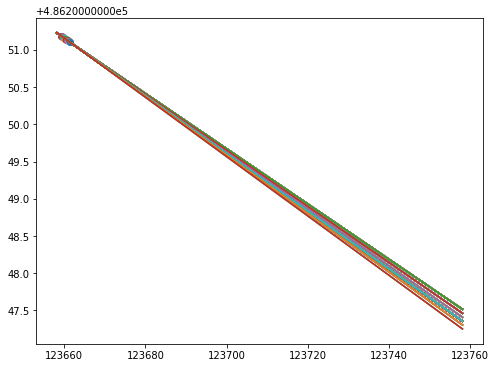

In [14]:
demo()


